In [33]:
from sklearn.metrics import mean_absolute_error, \
    r2_score
from sklearn.ensemble import  RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import torch
import torch.nn as nn
import numpy as np

In [34]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

In [147]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier


class FeedbackHHC:
    def __init__(self, file_path):
        self.data = pd.read_csv(file_path)

    def iqr_outliers(self, col):
        Q1 = self.data[col].quantile(0.25)
        Q3 = self.data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_threshold = Q1 - 7 * IQR
        upper_threshold = Q3 + 7 * IQR
        self.data[col] = np.where(
                    (self.data[col] < lower_threshold) | (self.data[col] > upper_threshold),
                    np.nan,
                    self.data[col]
                )
        
    def preprocess_data(self):

        # delete duplicates & irrelevant data
        self.data.drop_duplicates(inplace=True)
        self.data.drop(['Certification Date','Footnote for how often patients got better at taking their drugs correctly by mouth','Footnote for how often patients got better at walking or moving around','Footnote for how often the home health team determined whether patients received a flu shot for the current flu season','Footnote for how much Medicare spends on an episode of care at this agency, compared to '
                        'Medicare spending across all agencies nationally', 'Footnote for PPR Risk-Standardized Rate',
                        'Footnote for DTC Risk-Standardized Rate', 'Footnote for Application of Percent of Long Term '
                                                                   'Care Hospital Patients with an Admission and '
                                                                   'Discharge Functional Assessment and a Care Plan '
                                                                   'that Addresses Function', 'Footnote for Percent of '
                                                                                              'Residents Experiencing '
                                                                                              'One or More Falls with '
                                                                                              'Major Injury',
                        'Footnote for how often physician-recommended actions to address medication issues were '
                        'completely timely', 'Footnote Changes in skin integrity post-acute care: pressure '
                                             'ulcer/injury', 'Footnote for how often patients receiving home health '
                                                             'care needed urgent, unplanned care in the ER without '
                                                             'being admitted', 'Footnote for how often home health '
                                                                               'patients had to be admitted to the '
                                                                               'hospital', 'Footnote for how often '
                                                                                           'patients got better at '
                                                                                           'taking'
                                                                                           'their drugs correctly by '
                                                                                           'mouth', 'Footnote for how '
                                                                                                    'often patients\' '
                                                                                                    'breathing improved',
                        'Footnote for how often patients got better at bathing', 'Footnote for how often patients got '
                                                                                 'better at getting in and out of '
                                                                                 'bed', 'Footnote for how often '
                                                                                        'patients got better at walking'
                                                                                        'or moving around',
                        'Footnote for how'
                        'often the home '
                        'health team '
                        'determined whether '
                        'patients received a '
                        'flu shot for the '
                        'current flu '
                        'season',
                        'Footnote for how often the home health team began their patients\' care in a timely manner',
                        'Footnote for PPH Risk-Standardized Rate', 'Footnote for quality of patient care star rating',
                        'Provider ID', 'Provider Name', 'Hospital Name', 'Address', 'City/Town', 'State', 'ZIP Code',
                        'County Name', 'Telephone Number', 'Hospital Type', 'Type of Ownership', 'Emergency '
                                                                                                 'Services',
                        'Meets criteria for meaningful use of EHRs', 'Hospital overall rating', 'Mortality national '
                                                                                                'comparison',
                        'Safety of care national comparison', 'Readmission national comparison', 'Patient experience '
                                                                                                 'national '
                                                                                                 'comparison',
                        'Effectiveness of care national comparison', 'Timeliness of care national comparison',
                        'Efficient use of medical imaging national comparison', 'CMS Certification Number (CCN)'],
                       axis=1, inplace=True, errors='ignore')
        
        # delete rows with value '-' instead of 'Yes' or 'No'
        yes_no_columns = [
            'Offers Nursing Care Services',
            'Offers Physical Therapy Services',
            'Offers Occupational Therapy Services',
            'Offers Speech Pathology Services',
            'Offers Medical Social Services',
            'Offers Home Health Aide Services'
        ]
        for col in yes_no_columns:
            self.data[col].replace('-', np.nan, inplace=True)
        self.data.dropna(subset=yes_no_columns, how='any', inplace=True)

        # replace 'Yes' in columns with 1 and 'No' with 0
        self.data.replace('Yes', 1, inplace=True)
        self.data.replace('No', 0, inplace=True)

        other_columns = ['DTC Performance Categorization', 'PPH Performance Categorization',
                    'PPR Performance Categorization']
        
        # inlocuim valorile numerice lipsa cu media
        for col in self.data.columns:
            try:
                if col not in other_columns and col not in yes_no_columns:
                    self.data[col] = pd.to_numeric(self.data[col], errors='coerce')
                    self.data[col].fillna(self.data[col].mean(), inplace=True)
                    self.data[col] = self.data[col].round()
            except ValueError:
                pass

        # replace strings with numerical values
        self.data.replace('Not Available', 0, inplace=True)
        self.data.replace('-', np.nan, inplace=True)
        self.data.replace('Same As National Rate', 0, inplace=True)
        self.data.replace('Better Than National Rate', 1, inplace=True)
        self.data.replace('Worse Than National Rate', -1, inplace=True)

        # remove outliers
        for col in self.data.columns:
            if col not in other_columns and col not in yes_no_columns:
                self.iqr_outliers(col)
        
        # drop rows containing NaN (outliers)
        self.data.dropna(inplace=True)

    def exploratory_analysis(self):
        numeric_columns = self.data.select_dtypes(include=np.number).columns
        numeric_data = self.data[numeric_columns]

        print("The average for the attributes:\n", numeric_data.mean())
        print("\nThe median for the attributes:\n", numeric_data.median())

        for col in numeric_columns:
            plt.figure(figsize=(6, 4)) 
            numeric_data[col].hist(bins=20, color='lightpink', edgecolor='black')
            plt.title(col)
            plt.show()

    def select_attributes_pca(self):
        numeric_columns = self.data.select_dtypes(include=np.number).columns
        numeric_data = self.data[numeric_columns]

        pca=PCA()
        pca.fit(numeric_data)
        
        # calculam variația cumulativă și determinam numarul de componente
        variatie_cumulativa = np.cumsum(pca.explained_variance_ratio_)
        numar_componente = np.where(variatie_cumulativa > 0.95)[0][0] + 1

        # aplicam PCA cu numarul optim de componente
        pca_optim = PCA(n_components=numar_componente)
        pca_optim.fit(numeric_data)

        # afisam atributele selectate
        print("Selected attributes are:")
        print("--------------------------------------------------------------------------------------------------------------------------------------------\n")
        for i in range(numar_componente):
            print(f"Main component #{i + 1}:")
            component = pca_optim.components_[i]
            importance = pd.Series(component, index=numeric_columns)
            display(importance.sort_values(ascending=False))
    

        # vizualizarea atributelor selectate
        plt.figure(figsize=(10, 6))
        plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='lightpink')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title('Cumulative Variation of Explained Variance')
        plt.grid()
        plt.show()
    
    def train_random_forest_regressor(self):
        X = self.data.drop('Quality of patient care star rating', axis=1)
        y = self.data['Quality of patient care star rating']
        print(y)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        print(y_test)

        rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

        rf_regressor.fit(X_train, y_train)

        y_pred = rf_regressor.predict(X_test)
        
        #increment pentru rotunjirea valorilor prezise
        increment = 0.5

        y_pred_rounded = [round(pred / increment) * increment for pred in y_pred]

        
        output_tuples = [(f"Predicted: {pred:.2f}", f"Actual: {val:.2f}") for pred, val in zip(y_pred_rounded, y_test.values)]

        for predicted, actual in output_tuples:
            print(predicted, actual)

        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"Random Forest Regressor Mean Absolute Error: {mae:.2f}")
        print(f"Random Forest Regressor R2 Score: {r2:.2f}")

        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred_rounded, color='blue')
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red', linewidth=2)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values (Rounded)')
        plt.title('Actual vs Predicted Values - Random Forest Regressor (Rounded)')
        plt.show()
        
    def train_random_forest_classifier(self):
        X = self.data.drop('Quality of patient care star rating', axis=1)
        y = np.where(self.data['Quality of patient care star rating'] > 3.5, 1, 0)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_classifier.fit(X_train, y_train)

        # Predict probabilities for ROC curve
        y_pred_prob = rf_classifier.predict_proba(X_test)

        # Plot the ROC curve for class 0
        fpr_0, tpr_0, _ = roc_curve(y_test, y_pred_prob[:, 0])
        roc_auc_0 = auc(fpr_0, tpr_0)

        # Plot the ROC curve for class 1
        fpr_1, tpr_1, _ = roc_curve(y_test, y_pred_prob[:, 1])
        roc_auc_1 = auc(fpr_1, tpr_1)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr_0, tpr_0, color='darkorange', lw=2, label=f'AUC (Class 0) = {roc_auc_0:.2f}')
        plt.plot(fpr_1, tpr_1, color='green', lw=2, label=f'AUC (Class 1) = {roc_auc_1:.2f}')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic Curve')
        plt.legend(loc='lower right')
        plt.show()

        # Print accuracy and confusion matrix
        y_pred = rf_classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        print(f"Accuracy: {accuracy:.2f}")
        conf_matrix = confusion_matrix(y_test, y_pred)
        conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
        print("Confusion Matrix:")
        print(conf_matrix_df)


    def train_random_forest_classifier_multiclass(self):
        X = self.data.drop('Quality of patient care star rating', axis=1)
        y = self.data['Quality of patient care star rating']

        # Binarize the target variable for multi-class classification
        y_bin = label_binarize(y, classes=np.unique(y))

        X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)

        rf_classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
        rf_classifier.fit(X_train, y_train)

        # Predict probabilities for each class
        y_pred_prob = rf_classifier.predict_proba(X_test)

        # Plot ROC curve for each class
        plt.figure(figsize=(8, 6))
        for i in range(len(np.unique(y))):
            fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic Curve - Multi-Class Classification')
        plt.legend(loc='lower right')
        plt.show()

        # Print ROC AUC values for each class
        classes = np.unique(y)
        for i in range(len(classes)):
            class_auc = roc_auc_score(y_test[:, i], y_pred_prob[:, i])
            print(f"AUC for Class '{classes[i]}': {class_auc:.2%}")
            
    def train_svm_classifier(self):
        X = self.data.drop('Quality of patient care star rating', axis=1)
        y = np.where(self.data['Quality of patient care star rating'] > 3.5, 1, 0)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        svm_classifier = SVC(probability=True, random_state=42)
        svm_classifier.fit(X_train, y_train)

        # Predict probabilities for ROC curve
        y_pred_prob = svm_classifier.predict_proba(X_test)

        # Plot the ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic Curve - Binary Classification')
        plt.legend(loc='lower right')
        plt.show()

        # Print accuracy and confusion matrix
        y_pred = svm_classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        print(f"Accuracy: {accuracy:.2f}")
        conf_matrix = confusion_matrix(y_test, y_pred)
        conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
        print("Confusion Matrix:")
        print(conf_matrix_df)

    def train_svm_classifier_multiclass(self):
        X = self.data.drop('Quality of patient care star rating', axis=1)
        y = self.data['Quality of patient care star rating']

        # Binarize the target variable for multi-class classification
        y_bin = label_binarize(y, classes=np.unique(y))

        X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        svm_classifier = OneVsRestClassifier(SVC(probability=True, random_state=42))
        svm_classifier.fit(X_train, y_train)

        # Predict probabilities for each class
        y_pred_prob = svm_classifier.predict_proba(X_test)

        # Plot ROC curve for each class
        plt.figure(figsize=(8, 6))
        for i in range(len(np.unique(y))):
            fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic Curve - Multi-Class Classification')
        plt.legend(loc='lower right')
        plt.show()

        # Print ROC AUC values for each class
        classes = np.unique(y)
        for i in range(len(classes)):
            class_auc = roc_auc_score(y_test[:, i], y_pred_prob[:, i])
            print(f"AUC for Class '{classes[i]}': {class_auc:.2%}")


    def train_neural_network(self, batch_size=32):
        X = self.data.drop('Quality of patient care star rating', axis=1)
        y = self.data['Quality of patient care star rating']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Convert data to PyTorch tensors
        X_train_tensor = torch.FloatTensor(X_train.values)
        y_train_tensor = torch.FloatTensor(y_train.values).view(-1, 1)
        X_test_tensor = torch.FloatTensor(X_test.values)
        y_test_tensor = torch.FloatTensor(y_test.values).view(-1, 1)

        # Initialize the neural network
        input_size = X_train.shape[1]
        neural_network = NeuralNetwork(input_size)

        # Define loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(neural_network.parameters(), lr=0.01)

        # Train the neural network with batches
        num_epochs = 100
        for epoch in range(num_epochs):
            # Shuffle data and split into batches
            indices = np.arange(len(X_train))
            np.random.shuffle(indices)
            for i in range(0, len(indices), batch_size):
                batch_indices = indices[i:i + batch_size]
                X_batch = X_train_tensor[batch_indices]
                y_batch = y_train_tensor[batch_indices]

                optimizer.zero_grad()
                outputs = neural_network(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()

            # Calculate training accuracy
            with torch.no_grad():
                y_train_pred_tensor = neural_network(X_train_tensor)
                train_predictions = np.round(y_train_pred_tensor.numpy().flatten())
                correct_train_predictions = sum(train_predictions == y_train)
                total_train_labels = len(y_train)
                train_accuracy = (correct_train_predictions * 100) / total_train_labels

            # Print training accuracy
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Training Accuracy: {train_accuracy:.2f}%')

        # Evaluation on testing data
        with torch.no_grad():
            y_test_pred_tensor = neural_network(X_test_tensor)

        # Convert predictions to NumPy arrays
        y_test_pred = y_test_pred_tensor.numpy().flatten()

        # Calculate testing accuracy
        test_predictions = np.round(y_test_pred)
        correct_test_predictions = sum(test_predictions == y_test_tensor.numpy().flatten())
        total_test_labels = len(y_test)
        test_accuracy = (correct_test_predictions * 100) / total_test_labels

        # Print testing accuracy
        print(f'Testing Accuracy: {test_accuracy:.2f}%')

        # Visualization
        plt.figure(figsize=(12, 6))

        # Plotting testing data
        plt.scatter(y_test, y_test_pred, color='green', label='Predicted')
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red', linewidth=2)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title('Testing Data - Actual vs Predicted Values')
        plt.legend()

        plt.tight_layout()
        plt.show()


    def compare_models_performance(self):
        X = self.data.drop('Quality of patient care star rating', axis=1)
        y = np.where(self.data['Quality of patient care star rating'] > 3.5, 1, 0)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Train Random Forest Classifier
        rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_classifier.fit(X_train, y_train)
        y_pred_rf = rf_classifier.predict(X_test)
        accuracy_rf = accuracy_score(y_test, y_pred_rf)
        auc_rf = roc_auc_score(y_test, rf_classifier.predict_proba(X_test)[:, 1])

        # Train SVM Classifier
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        svm_classifier = SVC(probability=True, random_state=42)
        svm_classifier.fit(X_train_scaled, y_train)
        y_pred_svm = svm_classifier.predict(X_test_scaled)
        accuracy_svm = accuracy_score(y_test, y_pred_svm)
        auc_svm = roc_auc_score(y_test, svm_classifier.predict_proba(X_test_scaled)[:, 1])

        # Display results
        print("Random Forest Classifier:")
        print(f"Accuracy: {accuracy_rf:.2f}")
        print(f"AUC: {auc_rf:.2f}")
        print(classification_report(y_test, y_pred_rf))

        print("\nSVM Classifier:")
        print(f"Accuracy: {accuracy_svm:.2f}")
        print(f"AUC: {auc_svm:.2f}")
        print(classification_report(y_test, y_pred_svm))

        # Plot ROC Curves
        fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_classifier.predict_proba(X_test)[:, 1])
        fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_classifier.predict_proba(X_test_scaled)[:, 1])

        plt.figure(figsize=(8, 6))
        plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'Random Forest (AUC = {auc_rf:.2f})')
        plt.plot(fpr_svm, tpr_svm, color='green', lw=2, label=f'SVM (AUC = {auc_svm:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic Curve - Random Forest vs SVM')
        plt.legend(loc='lower right')
        plt.show()
        


Principal Component Analysis (PCA) is a statistical method used for dimensionality reduction in datasets with multiple correlated variables. 
It transforms these variables into a set of uncorrelated components, capturing the maximum variance in the data. 
PCA works by computing new variables (principal components) that are linear combinations of the original ones, ordered by the variance they explain. 
These components are orthogonal, ensuring unique information capture. It's employed for dimensionality reduction, simplifying complex data while retaining essential patterns. 
PCA involves a trade-off between dimensionality reduction and information loss, making it important to balance data compression with retaining meaningful insights.

Variance is a statistical measure of how spread out a set of values are around the mean. In the context of Principal Component Analysis (PCA), variance plays a key role. In PCA, variance represents the amount of information each principal component carries. Higher variance signifies that the component retains more information from the original data, making it more significant in representing the dataset's variability. PCA aims to maximize variance along its principal components to capture the most critical aspects of the data while reducing dimensionality.

Mean Absolute Error represents the average absolute difference between the predicted values and the actual values. It gives you a sense of the average magnitude of errors in your predictions. A lower value indicates better model performance.
R2 measures the proportion of the variance in the dependent variable (target) that is predictable from the independent variables (features). It ranges from 0 to 1, where 1 indicates a perfect fit.

0       4.0
1       2.0
2       3.0
3       4.0
4       4.0
       ... 
2344    4.0
2345    2.0
2346    3.0
2347    3.0
2348    3.0
Name: Quality of patient care star rating, Length: 2349, dtype: float64
1395    4.0
668     3.0
2002    3.0
808     2.0
1903    3.0
       ... 
324     3.0
2240    3.0
374     2.0
834     4.0
1541    4.0
Name: Quality of patient care star rating, Length: 470, dtype: float64
Predicted: 3.50 Actual: 4.00
Predicted: 3.00 Actual: 3.00
Predicted: 3.00 Actual: 3.00
Predicted: 2.00 Actual: 2.00
Predicted: 3.00 Actual: 3.00
Predicted: 5.00 Actual: 5.00
Predicted: 3.50 Actual: 4.00
Predicted: 3.00 Actual: 3.00
Predicted: 2.50 Actual: 3.00
Predicted: 3.00 Actual: 3.00
Predicted: 4.50 Actual: 4.00
Predicted: 3.00 Actual: 3.00
Predicted: 2.00 Actual: 2.00
Predicted: 3.00 Actual: 3.00
Predicted: 2.00 Actual: 2.00
Predicted: 3.00 Actual: 3.00
Predicted: 2.50 Actual: 2.00
Predicted: 4.00 Actual: 4.00
Predicted: 4.00 Actual: 4.00
Predicted: 2.00 Actual: 2.00
Predicted: 4.

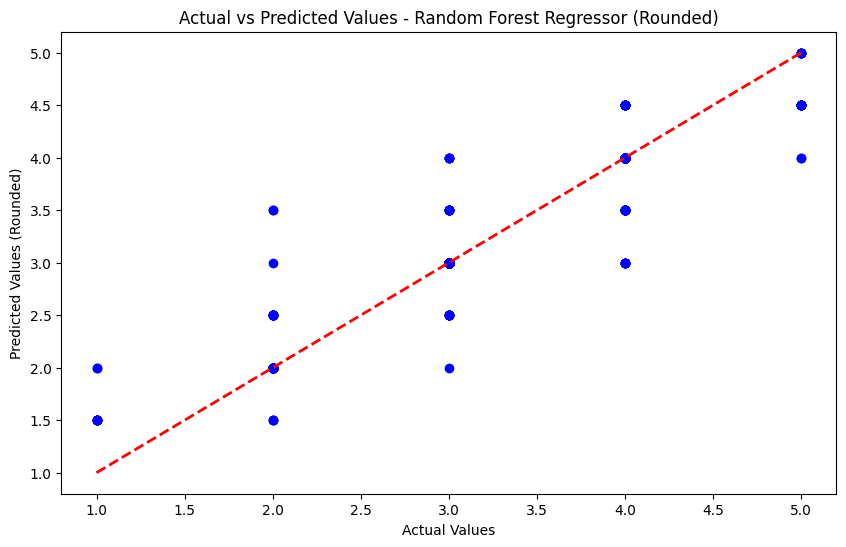

Epoch [10/100], Loss: 0.1825, Training Accuracy: 69.29%
Epoch [20/100], Loss: 0.2641, Training Accuracy: 73.71%
Epoch [30/100], Loss: 0.1081, Training Accuracy: 81.59%
Epoch [40/100], Loss: 0.3569, Training Accuracy: 78.29%
Epoch [50/100], Loss: 0.1350, Training Accuracy: 83.34%
Epoch [60/100], Loss: 0.1957, Training Accuracy: 81.85%
Epoch [70/100], Loss: 0.2670, Training Accuracy: 83.66%
Epoch [80/100], Loss: 0.1498, Training Accuracy: 81.59%
Epoch [90/100], Loss: 0.1928, Training Accuracy: 70.57%
Epoch [100/100], Loss: 0.1027, Training Accuracy: 76.05%
Testing Accuracy: 77.45%


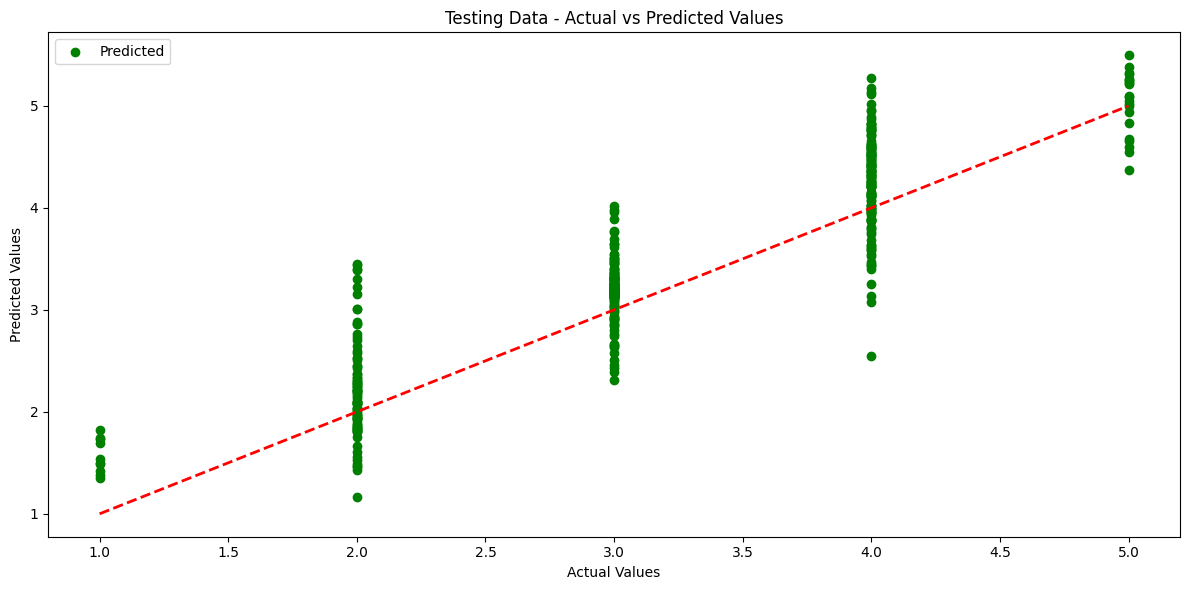

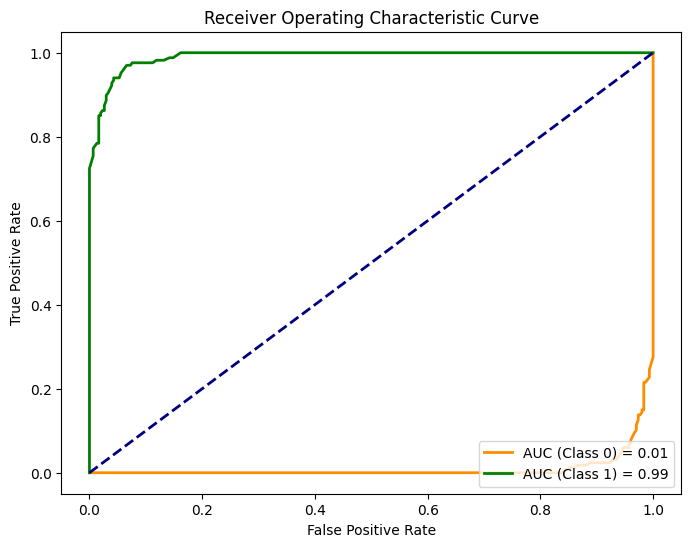

Accuracy: 0.95
Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                 290                  13
Actual Positive                  10                 157


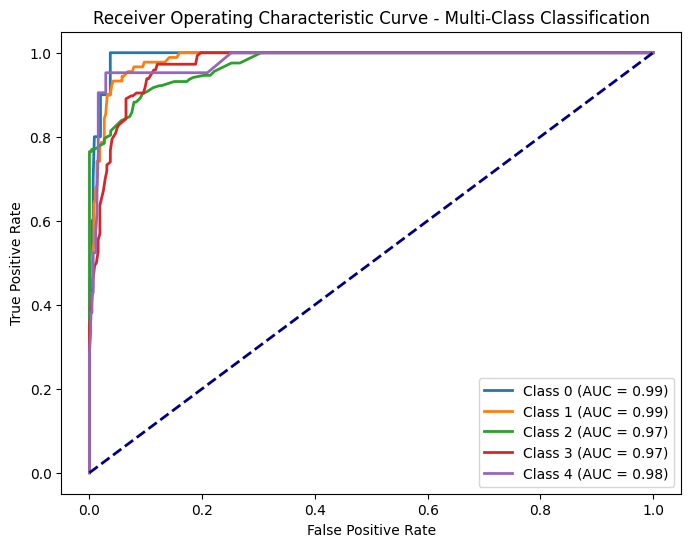

AUC for Class '1.0': 99.24%
AUC for Class '2.0': 98.52%
AUC for Class '3.0': 97.27%
AUC for Class '4.0': 97.31%
AUC for Class '5.0': 98.13%


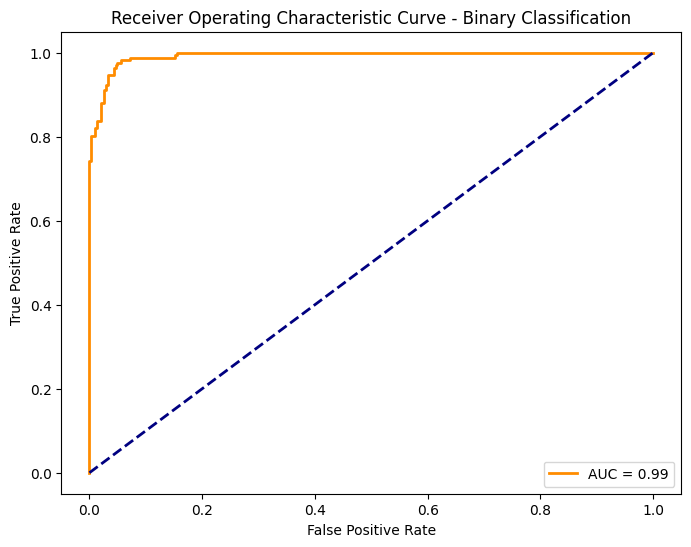

Accuracy: 0.95
Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                 293                  10
Actual Positive                  13                 154


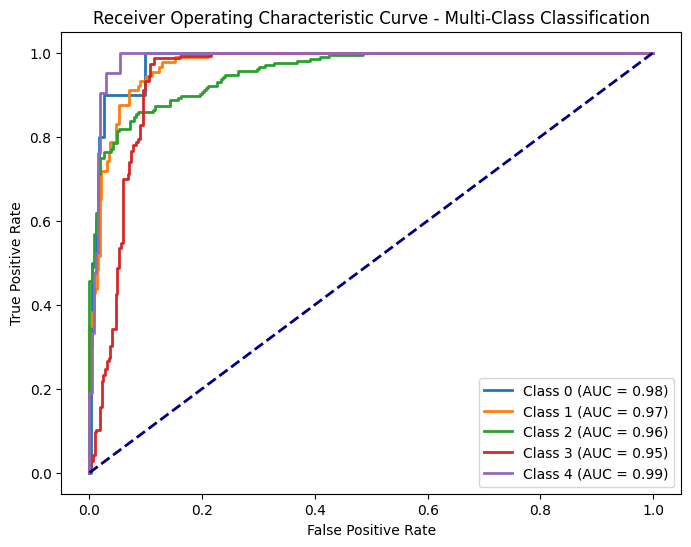

AUC for Class '1.0': 98.15%
AUC for Class '2.0': 97.39%
AUC for Class '3.0': 95.58%
AUC for Class '4.0': 94.51%
AUC for Class '5.0': 98.74%
Random Forest Classifier:
Accuracy: 0.95
AUC: 0.99
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       303
           1       0.92      0.94      0.93       167

    accuracy                           0.95       470
   macro avg       0.95      0.95      0.95       470
weighted avg       0.95      0.95      0.95       470


SVM Classifier:
Accuracy: 0.95
AUC: 0.99
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       303
           1       0.94      0.92      0.93       167

    accuracy                           0.95       470
   macro avg       0.95      0.94      0.95       470
weighted avg       0.95      0.95      0.95       470



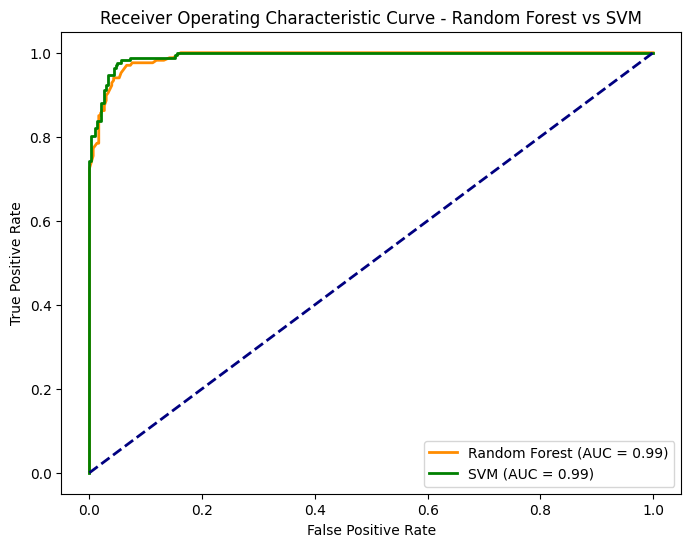

In [148]:
def main():
    data = FeedbackHHC(r'HH_Provider_Oct2023.csv')
    #display(data.data)

    data.preprocess_data()
    #display(data.data)
    data.data.to_csv('preprocessed_data.csv', index=False)
        
    # data.exploratory_analysis()
    # data.select_attributes_pca()
    
    preprocessed_data = FeedbackHHC('preprocessed_data.csv')


    preprocessed_data.train_random_forest_regressor()
    preprocessed_data.train_neural_network()
    
    preprocessed_data.train_random_forest_classifier()
    preprocessed_data.train_random_forest_classifier_multiclass()
    
    preprocessed_data.train_svm_classifier()
    preprocessed_data.train_svm_classifier_multiclass()

    preprocessed_data.compare_models_performance()


if __name__ == "__main__":
    main()